In [1]:
pip install pycaret

In [3]:
pip install optuna

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 364.4/364.4 kB 19.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 233.5/233.5 kB 18.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 78.6/78.6 kB 6.5 MB/s eta 0:00:00


1. Loading and Exploring Data
Dataset Shape: (891, 12)

Missing Values:
 PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

Feature Statistics:
        PassengerId    Survived      Pclass         Age       SibSp  \
count   891.000000  891.000000  891.000000  714.000000  891.000000   
mean    446.000000    0.383838    2.308642   29.699118    0.523008   
std     257.353842    0.486592    0.836071   14.526497    1.102743   
min       1.000000    0.000000    1.000000    0.420000    0.000000   
25%     223.500000    0.000000    2.000000   20.125000    0.000000   
50%     446.000000    0.000000    3.000000   28.000000    0.000000   
75%     668.500000    1.000000    3.000000   38.000000    1.000000   
max     891.000000    1.000000    3.000000   80.000000    8.000000   

            Parch        Fare  
c

,Description,Value
0,Session id,42
1,Target,Survived
2,Target type,Binary
3,Original data shape,"(891, 17)"
4,Transformed data shape,"(891, 42)"
5,Transformed train set shape,"(623, 42)"
6,Transformed test set shape,"(268, 42)"
7,Numeric features,5
8,Categorical features,7
9,Preprocess,True


,Model,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC,TT (Sec)
gbc,Gradient Boosting Classifier,0.8299,0.8679,0.7368,0.8103,0.7680,0.6346,0.6399,0.7110
rf,Random Forest Classifier,0.8234,0.8676,0.7286,0.8002,0.7587,0.6204,0.6258,0.7030
lightgbm,Light Gradient Boosting Machine,0.8106,0.8656,0.7245,0.7737,0.7450,0.5950,0.5990,0.6730
xgboost,Extreme Gradient Boosting,0.8090,0.8532,0.7328,0.7686,0.7465,0.5939,0.5983,0.4530
ada,Ada Boost Classifier,0.8074,0.8527,0.7284,0.7646,0.7426,0.5894,0.5929,0.3800
lr,Logistic Regression,0.8058,0.8536,0.7409,0.7555,0.7437,0.5882,0.5926,0.2780
et,Extra Trees Classifier,0.8057,0.8523,0.7413,0.7555,0.7446,0.5884,0.5924,0.4410
ridge,Ridge Classifier,0.8025,0.8554,0.7326,0.7520,0.7392,0.5810,0.5841,0.2970
lda,Linear Discriminant Analysis,0.7993,0.8551,0.7243,0.7495,0.7336,0.5733,0.5766,0.2670
knn,K Neighbors Classifier,0.7784,0.8286,0.6449,0.7450,0.6866,0.5181,0.5242,0.4400


Processing:   0%|          | 0/67 [00:00<?, ?it/s]

[I 2025-01-03 15:24:04,244] A new study created in memory with name: no-name-b7a149ff-e2fd-4549-8fab-2d9cb492ed39



Top 3 Models:
                                    Model  Accuracy     AUC  Recall   Prec.  \
gbc          Gradient Boosting Classifier    0.8299  0.8679  0.7368  0.8103   
rf               Random Forest Classifier    0.8234  0.8676  0.7286  0.8002   
lightgbm  Light Gradient Boosting Machine    0.8106  0.8656  0.7245  0.7737   

              F1   Kappa     MCC  TT (Sec)  
gbc       0.7680  0.6346  0.6399     0.711  
rf        0.7587  0.6204  0.6258     0.703  
lightgbm  0.7450  0.5950  0.5990     0.673  

4. Optimizing Hyperparameters


[I 2025-01-03 15:24:12,311] Trial 0 finished with value: 0.8193019898311468 and parameters: {'n_estimators': 149, 'max_depth': 13, 'min_samples_split': 19}. Best is trial 0 with value: 0.8193019898311468.
[I 2025-01-03 15:24:42,642] Trial 1 finished with value: 0.805818843763731 and parameters: {'n_estimators': 897, 'max_depth': 9, 'min_samples_split': 20}. Best is trial 0 with value: 0.8193019898311468.
[I 2025-01-03 15:25:19,147] Trial 2 finished with value: 0.805818843763731 and parameters: {'n_estimators': 942, 'max_depth': 13, 'min_samples_split': 14}. Best is trial 0 with value: 0.8193019898311468.
[I 2025-01-03 15:25:53,052] Trial 3 finished with value: 0.806973824618668 and parameters: {'n_estimators': 730, 'max_depth': 12, 'min_samples_split': 5}. Best is trial 0 with value: 0.8193019898311468.
[I 2025-01-03 15:26:22,203] Trial 4 finished with value: 0.8069675475488042 and parameters: {'n_estimators': 814, 'max_depth': 8, 'min_samples_split': 6}. Best is trial 0 with value: 0.


Best Hyperparameters: {'n_estimators': 176, 'max_depth': 4, 'min_samples_split': 15}

5. Training Final Model


,Accuracy,AUC,Recall,Prec.,F1,Kappa,MCC
Fold,,,,,,,
0,0.8571,0.8964,0.8333,0.8000,0.8163,0.6995,0.6999
1,0.7778,0.8408,0.6250,0.7500,0.6818,0.5132,0.5183
2,0.8254,0.8013,0.7083,0.8095,0.7556,0.6207,0.6240
3,0.8387,0.9169,0.8696,0.7407,0.8000,0.6663,0.6723
4,0.8387,0.8750,0.6250,0.9375,0.7500,0.6379,0.6664
5,0.8871,0.8991,0.8333,0.8696,0.8511,0.7602,0.7607
6,0.8065,0.8728,0.7500,0.7500,0.7500,0.5921,0.5921
7,0.7742,0.7588,0.6667,0.7273,0.6957,0.5167,0.5179
8,0.8387,0.8772,0.7083,0.8500,0.7727,0.6493,0.6558


Processing:   0%|          | 0/4 [00:00<?, ?it/s]


6. Evaluating Final Model


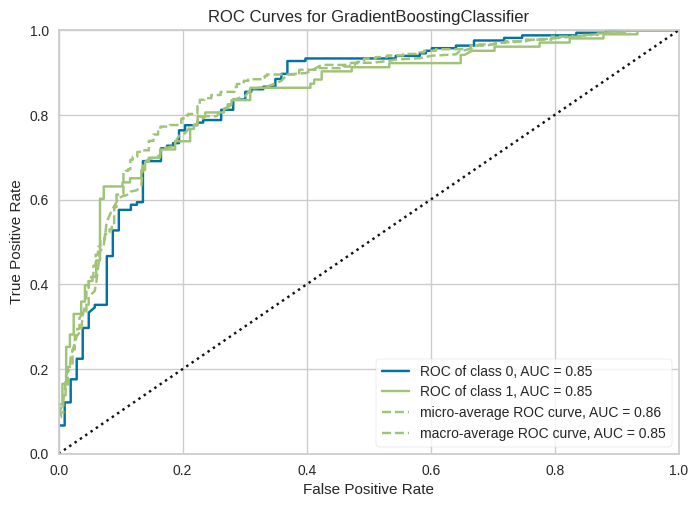

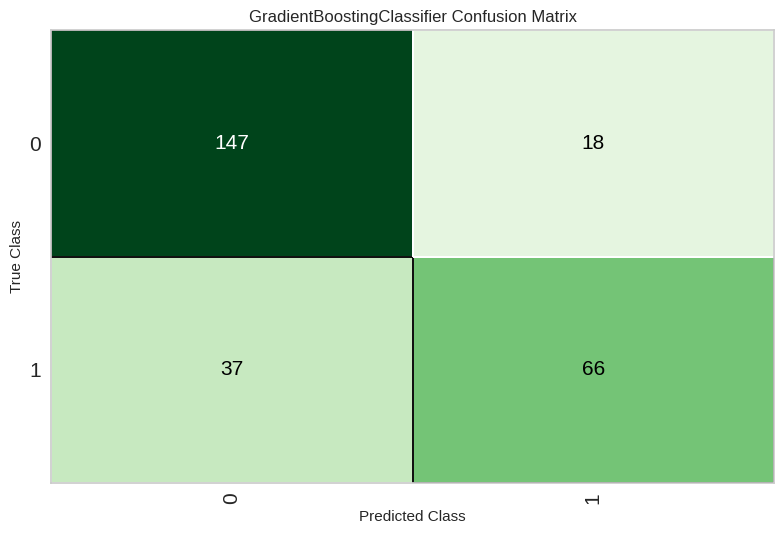


7. Saving Model
Transformation Pipeline and Model Successfully Saved


In [8]:
import pandas as pd
import numpy as np
from pycaret.classification import *
import optuna
from sklearn.model_selection import cross_val_score
from sklearn.base import clone
import warnings
warnings.filterwarnings('ignore')

# Data Loading and Initial Exploration
def load_and_explore():
    data = pd.read_csv('https://raw.githubusercontent.com/datasciencedojo/datasets/master/titanic.csv')
    print("Dataset Shape:", data.shape)
    print("\nMissing Values:\n", data.isnull().sum())
    print("\nFeature Statistics:\n", data.describe())
    return data

# Feature Engineering
def engineer_features(data):
    df = data.copy()

    # Title extraction
    df['Title'] = df['Name'].str.extract(' ([A-Za-z]+)\.', expand=False)
    title_mapping = {
        'Mr': 'Mr', 'Miss': 'Miss', 'Mrs': 'Mrs', 'Master': 'Master',
        'Lady': 'Rare', 'Countess': 'Rare', 'Capt': 'Rare', 'Col': 'Rare',
        'Don': 'Rare', 'Dr': 'Rare', 'Major': 'Rare', 'Rev': 'Rare',
        'Sir': 'Rare', 'Jonkheer': 'Rare', 'Dona': 'Rare', 'Mlle': 'Miss',
        'Ms': 'Miss', 'Mme': 'Mrs'
    }
    df['Title'] = df['Title'].map(title_mapping)

    # Family Features
    df['FamilySize'] = df['SibSp'] + df['Parch'] + 1
    df['IsAlone'] = (df['FamilySize'] == 1).astype(int)

    # Handle potential duplicate bin edges
    family_bins = pd.qcut(df['FamilySize'].rank(method='first'),
                         q=4,
                         labels=['Small', 'Medium', 'Large', 'Very Large'])
    df['FamilySizeGroup'] = family_bins

    # Age Features
    df['Age'] = df.groupby(['Title', 'Pclass'])['Age'].transform(
        lambda x: x.fillna(x.median())
    )
    age_bins = pd.qcut(df['Age'].rank(method='first'),
                      q=5,
                      labels=['Youngest', 'Young', 'Middle', 'Senior', 'Eldest'])
    df['AgeBin'] = age_bins

    # Fare Features
    df['Fare'] = df.groupby('Pclass')['Fare'].transform(
        lambda x: x.fillna(x.median())
    )
    fare_bins = pd.qcut(df['Fare'].rank(method='first'),
                       q=5,
                       labels=['Lowest', 'Low', 'Medium', 'High', 'Highest'])
    df['FareBin'] = fare_bins

    # Cabin and Embarked
    df['Deck'] = df['Cabin'].str[0].fillna('Unknown')
    df['Embarked'] = df['Embarked'].fillna(df['Embarked'].mode()[0])

    # Interaction Features
    df['Age*Class'] = df['Age'] * df['Pclass']
    df['Fare*Class'] = df['Fare'] * df['Pclass']

    # Drop unnecessary columns
    columns_to_drop = ['Name', 'PassengerId', 'Ticket', 'Cabin']
    df = df.drop(columns_to_drop, axis=1)

    return df

# Model Selection using PyCaret
def select_best_model(data):
    # Initialize setup
    exp = setup(
        data=data,
        target='Survived',
        numeric_features=['Age', 'Fare', 'FamilySize', 'Age*Class', 'Fare*Class'],
        categorical_features=['Sex', 'Embarked', 'Title', 'Deck',
                            'FamilySizeGroup', 'AgeBin', 'FareBin'],
        normalize=True,
        transformation=True,
        session_id=42
    )

    # Compare and select top models
    best_models = compare_models(n_select=3)
    return best_models

# Hyperparameter Optimization using Optuna
def optimize_hyperparameters(model, data):
    # Prepare data - encode categoricals
    X = pd.get_dummies(data.drop('Survived', axis=1), drop_first=True)
    y = data['Survived']

    def objective(trial):
        if str(type(model)).find('LGBMClassifier') != -1:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
                'num_leaves': trial.suggest_int('num_leaves', 20, 100)
            }
        elif str(type(model)).find('XGBClassifier') != -1:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'learning_rate': trial.suggest_loguniform('learning_rate', 0.01, 0.1),
                'subsample': trial.suggest_uniform('subsample', 0.6, 1.0)
            }
        else:
            params = {
                'n_estimators': trial.suggest_int('n_estimators', 100, 1000),
                'max_depth': trial.suggest_int('max_depth', 3, 15),
                'min_samples_split': trial.suggest_int('min_samples_split', 2, 20)
            }

        model_trial = clone(model)
        model_trial.set_params(**params)
        return cross_val_score(model_trial, X, y, cv=5, scoring='accuracy').mean()

    study = optuna.create_study(direction='maximize')
    study.optimize(objective, n_trials=50)
    return study.best_params



# Main execution
if __name__ == "__main__":
    print("1. Loading and Exploring Data")
    data = load_and_explore()

    print("\n2. Engineering Features")
    processed_data = engineer_features(data)

    print("\n3. Selecting Best Models")
    best_models = select_best_model(processed_data)
    print("\nTop 3 Models:")
    print(pull().head(3))

    print("\n4. Optimizing Hyperparameters")
    best_model = best_models[0]
    best_params = optimize_hyperparameters(best_model, processed_data)
    print("\nBest Hyperparameters:", best_params)

    print("\n5. Training Final Model")
    final_model = clone(best_model)
    final_model.set_params(**best_params)
    final_model = create_model(final_model)

    print("\n6. Evaluating Final Model")
    plot_model(final_model, plot='auc')
    plot_model(final_model, plot='confusion_matrix')

    print("\n7. Saving Model")
    save_model(final_model, 'optimized_titanic_model')